Order of Code

This is dr. Milchenko's boosted AE approach.

the residuals of one become the inputs for the next!

In [2]:
import numpy as np
# Note: all of this will be done with full-batch implementation. No regularization yet. No sparcity yet
import mnist_loader

import matplotlib.pyplot as plt
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()




In [3]:
training_data_segment = list(training_data)[:100]
unlabeled_data = np.array([data[0] for data in training_data_segment])
data = unlabeled_data.T.reshape(784,-1) # each example stored in a column

test_data_segment = list(test_data)[:10]
unlabeled_test_data = np.array([data[0] for data in test_data_segment])
test_data = unlabeled_test_data.T.reshape(784,-1) # each example stored in a colum

In [4]:
%matplotlib inline

In [38]:
def sigmoid(x):
#     print('max of x array is ' + str(np.amax(x)))
#     print('min of x is ' + str(np.amin(x)))
    return 1/(1+np.exp(-x))

def sp(sigma):
	return sigma*(1-sigma)

def get_minibatches(data, mb_length):
    '''Takes in data as np.array, with egs in columns and outputs examples in columns as np.array()'''
#     random.shuffle(data)  I think this will screw it up with data in columns
    data = data.T
    minibatches = [data[i:i+mb_length] for i in range(0,len(data),mb_length)] #means the last minibatch could be shorter
    return np.array(minibatches)

def get_rho_hat(data, w, b):
    a_hidden, a_out = feedforward(data,w,b)
    rho_hat = np.sum(a_hidden, axis = 1).reshape(len(a_hidden),1)/data.shape[1]
    return rho_hat

def feedforward(x, w, b):  # Note: all of this will be done with full-batch implementation. No regularization yet. No sparcity yet
    # x should have examples in columns!
    a_hidden = sigmoid(np.dot(w,x)+b[0])
    a_out = sigmoid(np.dot(w.transpose(),a_hidden)+b[1])
    return [a_hidden, a_out] # Examples are still stored in columns in the hidden layer
# B's will work, I just need to be careful when I recreate images.

# def backprop(x, w, b):
#     a_hidden, a_out = feedforward(x,w,b)
#     d_out = (a_out-x)*sp(a_out) # Using quad-cost for now
#     d_hidden = np.dot(w,d_out)*sp(a_hidden)

#     #dW_jk = a_k_l-1 * d_j
#     dC_dw_T = np.dot(d_out, a_hidden.transpose())
#     dC_dw_input = np.dot(d_hidden, x.transpose())

#     dC_dw = dC_dw_input+dC_dw_T.transpose()
#     dC_db = [np.sum(d_hidden, axis = 1).reshape(b[0].shape), np.sum(d_out, axis = 1).reshape(b[1].shape)] # put these in cells of a matrix
#     return dC_dw, dC_db


def backprop(x,w,b,rho,beta, rho_hat, sparse):
    a_hidden, a_out = feedforward(x,w,b)
    
    if sparse:
        KL_deriv = (beta*(-(rho/rho_hat)+((1-rho)/(1-rho_hat)))).reshape(len(a_hidden),1)
    else:
        KL_deriv = 0
        
    d_out = (a_out-x)*sp(a_out)

    d_hidden = (np.dot(w,d_out)+KL_deriv)*sp(a_hidden)

    dC_dw_T = np.dot(d_out, a_hidden.transpose())
    dC_dw_input = np.dot(d_hidden, x.transpose())

    dC_dw = dC_dw_input+dC_dw_T.transpose()
    dC_db = [np.sum(d_hidden, axis = 1).reshape(b[0].shape), np.sum(d_out, axis = 1).reshape(b[1].shape)] # put these in cells of a matrix
    return dC_dw, dC_db, rho_hat

def update_net(data,w,b,eta,mb_length,rho = 0, beta = 0, sparse = 0):
    if sparse:
        # if it's sparse, we need to get rho_hat
        rho_hat = get_rho_hat(data,w,b)
    else:
        rho_hat = [0,0]
    
    ### weight decay term here.
    lmbda = 0.00
        
    mbs = get_minibatches(data,mb_length)
    for mb in mbs:
        dC_dw, dC_db, rho_hat = backprop(mb.T, w, b,rho,beta,rho_hat,sparse)
        # Using gradient descent - lmbda/data.shape[1]*w
        w = w - (eta/mb.shape[1])*dC_dw-w*lmbda
        b[0] = b[0] - (eta/mb.shape[1])*dC_db[0]
        b[1] = b[1] - (eta/mb.shape[1])*dC_db[1]
        
    return w,b,rho_hat

def eval_err(data,w,b):
    prediction = feedforward(data,w,b)
    error = sum(sum((prediction[1] - data)**2))/(data.shape[1])
    return error

# use this guy if not including sparcity term
# def Grad_descent(data,w,b,iterations,sparse):
#     for i in range(iterations):
#         w,b = update_net(data,w,b)
        
#         if i%499 == 0:
#             print(eval_err(data,w,b))
#     return w,b
        
def SGD_sparse(data,w,b,epochs,eta,mb_length,report_freq,sparse = 0,rho = 0,beta = 0):
    rho_hat_avg = []
    for i in range(epochs):
        w,b,rho_hat = update_net(data,w,b,eta,mb_length,rho,beta,sparse) # updates over entire epoch
        rho_hat_avg.append(sum(rho_hat)/len(rho_hat))
        if i%report_freq == 0:
            print(eval_err(data,w,b))    
    
    return w,b,rho_hat_avg,rho_hat


#The boosting functions
def initialize(hidden_size):
    sizes = [784,hidden_size,784]
    b= [np.zeros((hidden_size,1)), np.zeros((784,1))]
    w = np.random.randn(sizes[1],sizes[0])/np.sqrt(sizes[0])
    return w,b

def train_boosters(num_layers, data, w_orig, b_orig, epochs,eta,mb_length,report_freq,sparse = 0,rho = 0.0,beta = 0): #Question, will we need customizable parameters fo
    ws = [w_orig]
    bs = [b_orig]
    residuals = []
    h1, a_out = feedforward(data,w_orig,b_orig)
    residual = a_out-data # This'll be some [784 x egs] matrix with examples in columns
    residuals.append(residual)
    
    for i in range(num_layers):
        print('training next layer')
        w,b = initialize(50)
        w,b,rho_hat_avg,rho_hat = SGD_sparse(residual, w, b, epochs,eta,mb_length,report_freq,sparse = 0,rho = 0.0,beta = 0)
        
        h1, a_out = feedforward(residual,w,b)
        residual = a_out-residual # This'll be some [784 x egs] matrix with examples in columns
        residuals.append(residual)
        
        ws.append(w)
        bs.append(b)
        
    return ws, bs, residuals

def fwd_boosted_AE(data,ws,bs):
    x = data
    residuals = []
    for i in range(len(ws)):
        h1,a_out = feedforward(x,ws[i],bs[i])
        residual = a_out-x
        residuals.append(residual)
        x = residual
    predictions = np.sum(residuals, axis = 0)
    # Now we need to just sum across 'residuals,' and we'll have our predictions.
    return predictions, residuals


In [40]:
hidden_size = 50
sizes = [784,hidden_size,784]
b= [np.zeros((hidden_size,1)), np.zeros((784,1))]
w = np.random.randn(sizes[1],sizes[0])/np.sqrt(sizes[0])
rho = 0.05
beta = 0
mb_length = 20
eta = 10
epochs = 500
report_freq = 50
# for i in range(1000):
#     w,b = update_net(data,w,b,rho,beta)

#     if i%499 == 0:
#         print(eval_err(data,w,b))
# SGD_params = (data,w,b,epochs,eta,mb_length,report_freq,0,0.0,0)
w,b,rho_hat_avg,rho_hat = SGD_sparse(data,w,b,epochs,eta,mb_length,report_freq,sparse = 0,rho = 0.0,beta = 0)
# w,b,rho_hat_avg,rho_hat = SGD_sparse(SGD_params)

ws, bs, residuals = train_boosters(3,data,w,b,epochs,eta,mb_length,report_freq,sparse = 0,rho = 0.0,beta = 0)

predictions = fwd_boosted_AE(data,ws,bs)
error = sum(sum((predictions - data)**2))/(data.shape[1])
print('the error between the predicted adn origianl is ' + str(error))





72.1172319503
20.8440197597
14.6453921303
11.5336503892
9.56110184813
8.22444527801
7.24244247719
6.46826780202
5.8671978283
5.38354489422
training next layer
44.2138737493
5.00067825764
4.81694852875
4.7589841826
4.72020831964
4.68481694014
4.65171399715
4.62151103034
4.59380250975
4.56832941742
training next layer
34.6474884941
4.65002689184
4.49546698097
4.44884839717
4.42419430813
4.40603493052
4.38965472671
4.37334912886
4.35668658809
4.33979427562
training next layer
36.0637135754
4.42672114268
4.33278976276
4.30605148356
4.29428099175
4.28796712652
4.28416317064
4.28168603479
4.27997904525
4.27875028497


ValueError: operands could not be broadcast together with shapes (2,) (784,100) 

(784, 1)
(784, 1)


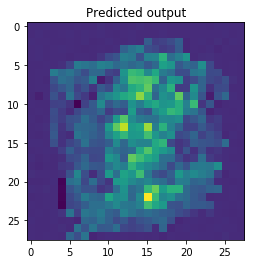

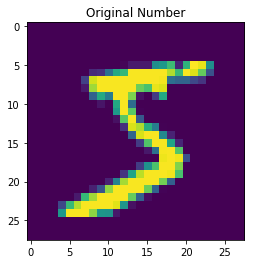

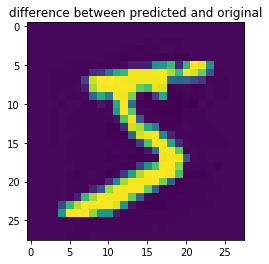

(784, 1)
(784, 1)


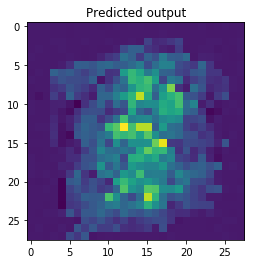

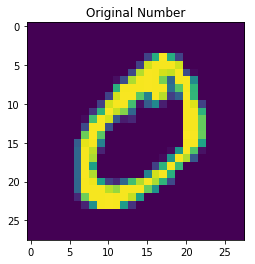

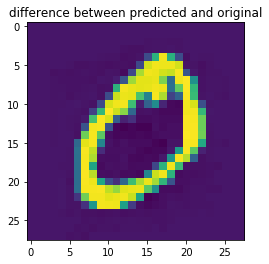

(784, 1)
(784, 1)


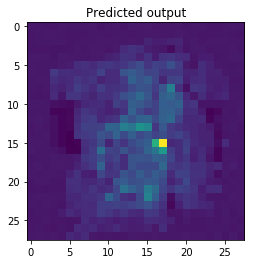

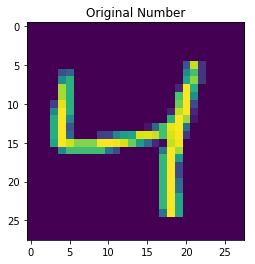

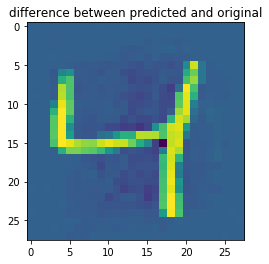

(784, 1)
(784, 1)


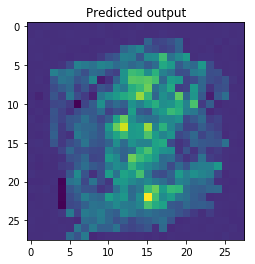

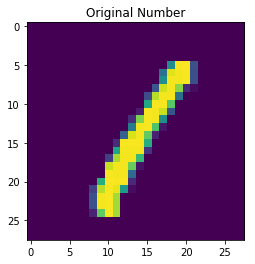

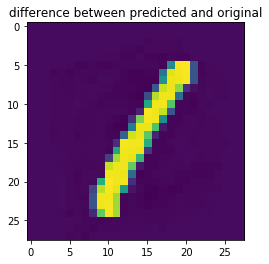

(784, 1)
(784, 1)


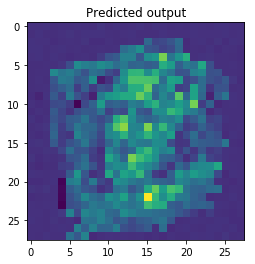

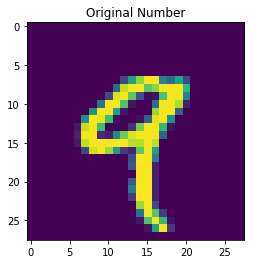

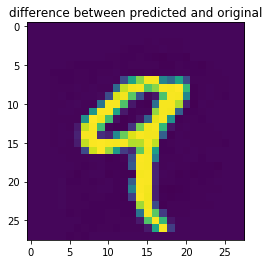

(784, 1)
(784, 1)


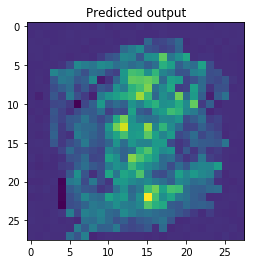

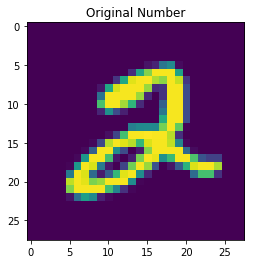

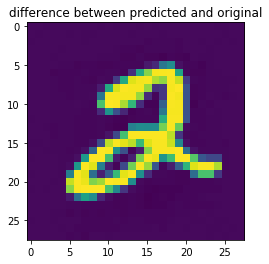

(784, 1)
(784, 1)


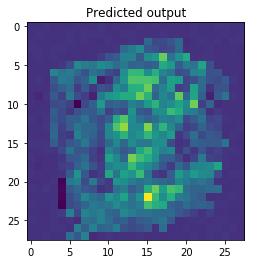

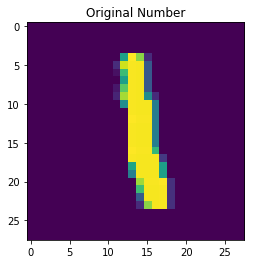

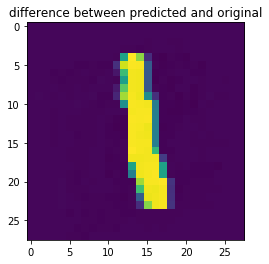

(784, 1)
(784, 1)


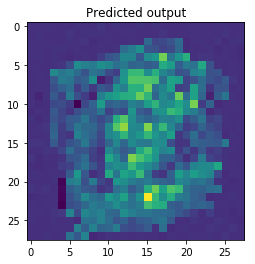

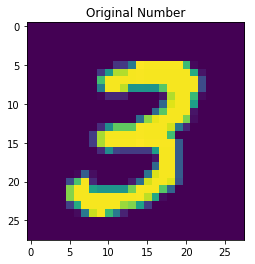

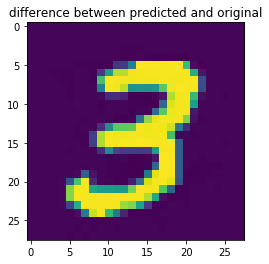

(784, 1)
(784, 1)


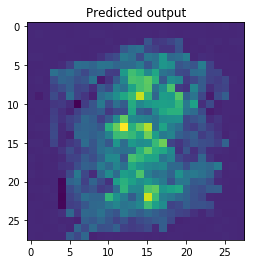

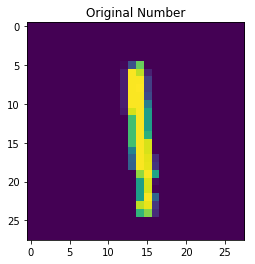

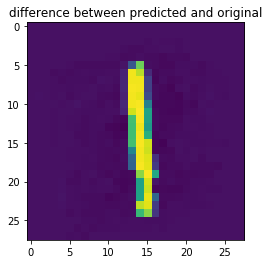

(784, 1)
(784, 1)


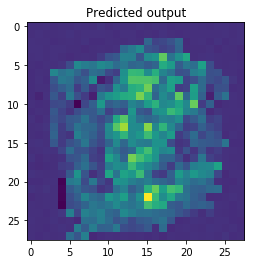

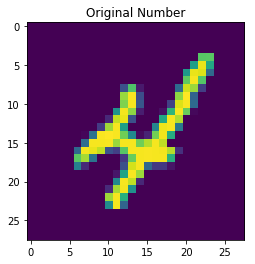

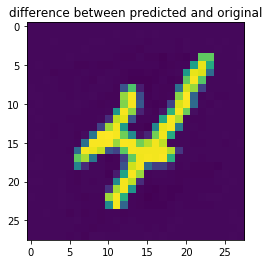

In [42]:
# digit = 6
input_data = data
for digit in range(10):
    output,residuals = fwd_boosted_AE(input_data.T[digit].reshape(784,1),ws,bs) # Have to transpose becasue egs are in columns.
    print(output.shape)
    
    print(output.shape)
    # print(output.shape)

    plt.imshow(np.array(output).reshape(28,28))
    plt.title('Predicted output')
    plt.show()

    plt.figure()
    plt.imshow(np.array(input_data.T[digit].reshape(28,28)))
    plt.title('Original Number')
    plt.show()

    plt.figure()
    plt.imshow(np.array(input_data.T[digit].reshape(28,28))-np.array(output).reshape(28,28))
    plt.title('difference between predicted and original')
    plt.show()

(4, 784, 1)
(4, 784)


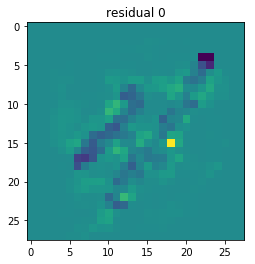

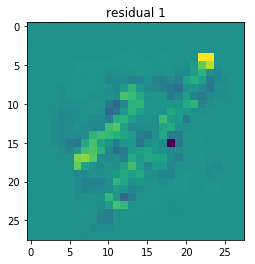

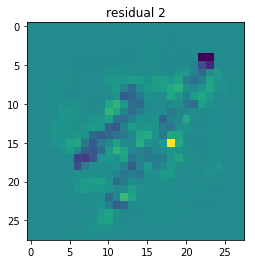

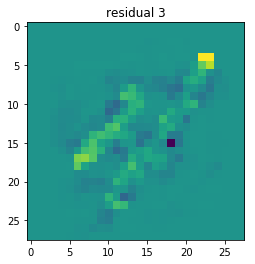

[ 5.7716879   5.80802388  5.79478967  5.79269591]


In [45]:
print(np.array(residuals).shape)
# good, as expected

sample_resids = np.array(residuals)[:,:,0]
print(sample_resids.shape)
for i in range(sample_resids.shape[0]):
    plt.imshow(sample_resids[i].reshape(28,28))
    plt.title('residual '+str(i))
    plt.show()
    
sqrd_resids = sample_resids**2
print(np.sum(sqrd_resids,axis = 1))

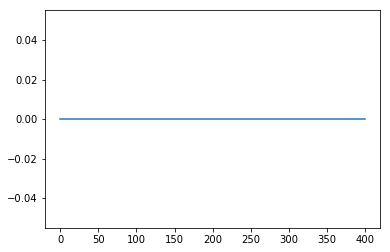

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(len(rho_hat_avg)),rho_hat_avg)
plt.show()

# Interesting, with minibatch approach, it doesn't overshoot. I think that's because it's not reported every minibatch, but 
#Instead once per epoch.

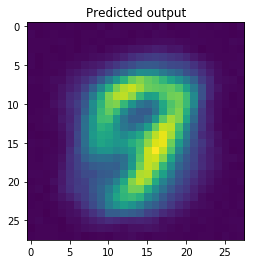

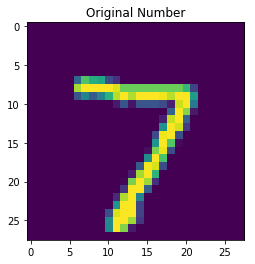

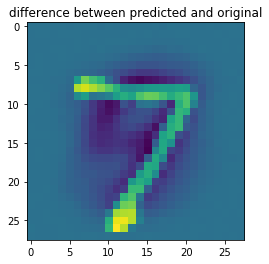

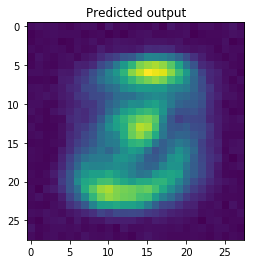

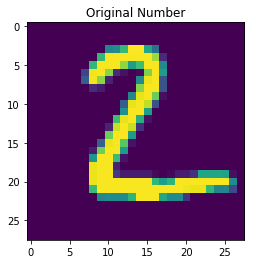

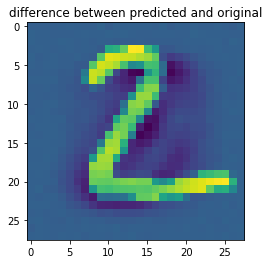

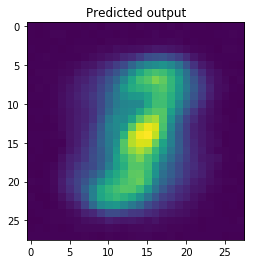

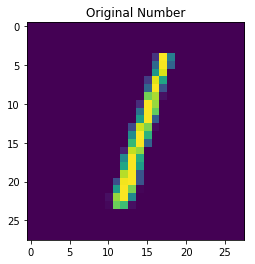

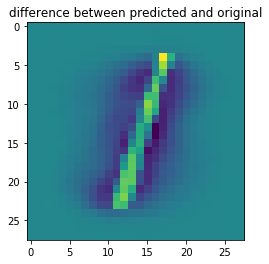

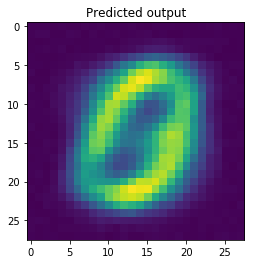

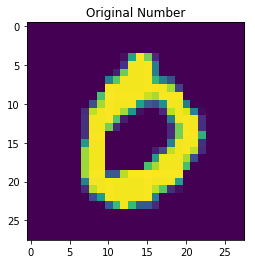

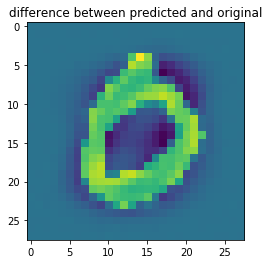

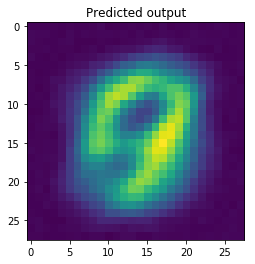

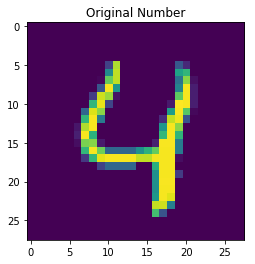

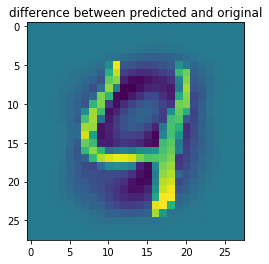

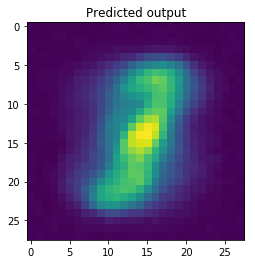

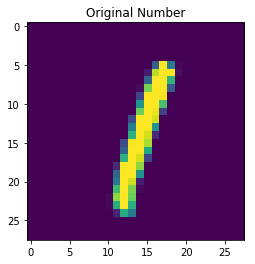

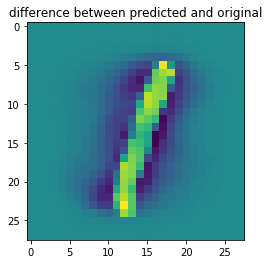

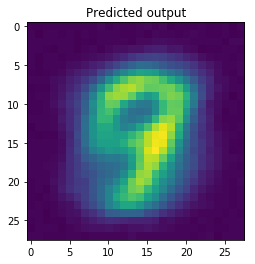

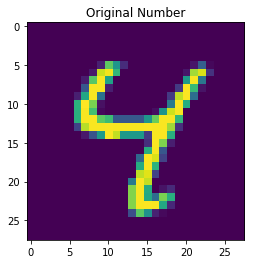

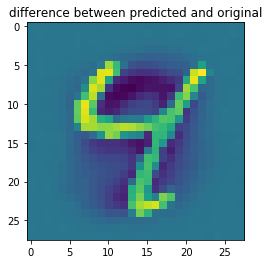

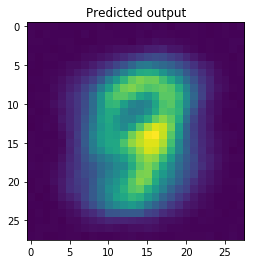

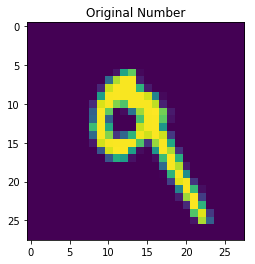

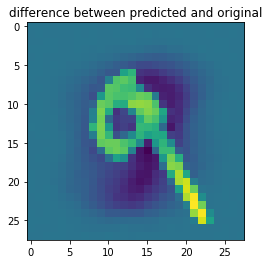

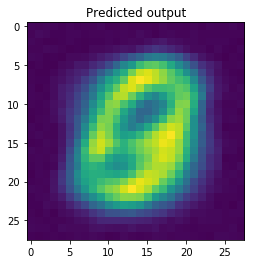

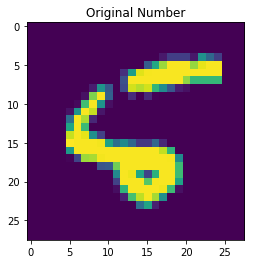

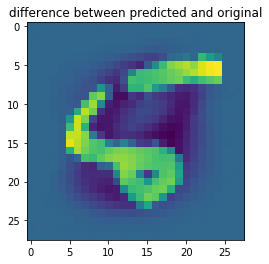

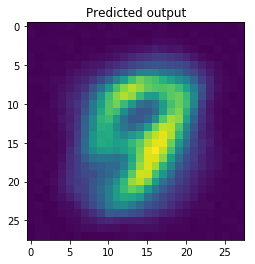

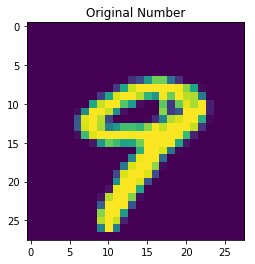

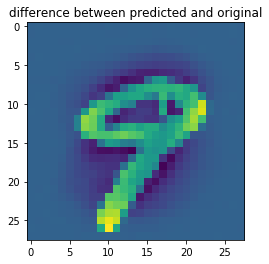

In [133]:
# digit = 6
for digit in range(10):
    output = feedforward(test_data.T[digit].reshape(784,1),w,b) # Have to transpose becasue egs are in columns.
    # print(data.T[0].shape)
    output = np.array(output[1])
    # print(output.shape)

    plt.imshow(np.array(output).reshape(28,28))
    plt.title('Predicted output')
    plt.show()

    plt.figure()
    plt.imshow(np.array(test_data.T[digit].reshape(28,28)))
    plt.title('Original Number')
    plt.show()

    plt.figure()
    plt.imshow(np.array(test_data.T[digit].reshape(28,28))-np.array(output).reshape(28,28))
    plt.title('difference between predicted and original')
    plt.show()

3
3
3
3
3
3
3
3
3
3


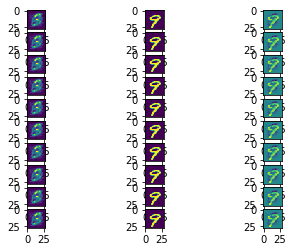

In [99]:

figure, axes = plt.subplots(10,3)
counter = 0
for axis in axes:
    print(len(axis))
    for digit in range(10):
        output_s = feedforward(test_data.T[digit].reshape(784,1),w,b) # Have to transpose becasue egs are in columns.
        output_s = np.array(output_s[1])
    
        image = axis[0].imshow(np.array(output_s).reshape(28,28))
#         axis.set_frame_on(False)
#         axis.set_axis_off()

        image = axis[1].imshow(np.array(test_data.T[digit].reshape(28,28)))
#         axis.set_frame_on(False)
#         axis.set_axis_off()
        
        image = axis[2].imshow(np.array(test_data.T[digit].reshape(28,28))-np.array(output_s).reshape(28,28))
#         axis.set_frame_on(False)
#         axis.set_axis_off()
plt.show()



    

In [75]:
mbs = get_minibatches(test_data,3)
print(mbs.shape)
print(mbs.shape[-1])
for mb in mbs:
    print(mb.T.shape)
# it's not going well if it's not a remainder of 0.
# Oh, it's actually not a problem. It's just a smaller mb. That's fine...
# for i in range(c.shape[-1]):
#     print c[...,i]
# Okay, actually, arrays suck for this kinda thing.

(4,)
4
(784, 3)
(784, 3)
(784, 3)
(784, 1)


In [36]:
print(test_data.T[1:5000].shape)

(9, 784)
